## Import all the libraries

In [1]:
import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from dask.diagnostics import ProgressBar
from datetime import date
import json
import os
import warnings
import seawater
import re

warnings.filterwarnings('ignore')


## Parameters

In [2]:
ymin=2010;mmin=1;dmin=1
ymax=2010;mmax=4;dmax=30
# depth of the desired comparison profile in m
depthmin=500
# radius of the circle around the profile location in which we take the modeled profiles, in °  
radius_max=0.25
# period of time around the profile sampling date in which we take the modeled profiles, in days
period=5
# minimum amount of model profiles to be considered to make a significant statistical comparison, for instance in a 1° square and 30-days window we have 2.6 millions modeled profiles, in a 0.5°x10 days 216 000
number_of_model_profiles=100000


In [3]:
datemin=datetime.date(ymin,mmin,dmin)
datemax=datetime.date(ymax,mmax,dmax)
jsonfile='txt/MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.json'

## Read the jsonfile

In [4]:
sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)


In [5]:
vert_standart=np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
                   110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,
                   420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,
                   820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,
                   1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000])
indz=np.where(vert_standart>depthmin)
vert_standart_red=vert_standart[0:np.min(indz[0])-1]

all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))
all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart_red)))


In [14]:
len(vert_standart_red)

51

In [6]:
for prof in np.arange(nb_profilesEN4):
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    dsprof=xr.open_dataset(outname)

    depth_en4=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']
    obs_lat=dsprof['latitude_profileEN4']
    obs_lon=dsprof['longitude_profileEN4']
    obs_time=dsprof['time_profileEN4']
    
    # Project the profile to standart vertical levels
    temp_en4_standart=np.interp(vert_standart_red,depth_en4,temp_en4)
    salt_en4_standart=np.interp(vert_standart_red,depth_en4,salt_en4)
    mean_temp_model_standart=np.interp(vert_standart_red,depth_en4,mean_temp_model)
    mean_salt_model_standart=np.interp(vert_standart_red,depth_en4,mean_salt_model)
    percent10_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent10_temp_model)
    percent10_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent10_salt_model)
    percent90_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent90_temp_model)
    percent90_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent90_salt_model)

    #Fill the all profiles
    all_temp_mean_model[prof,:]=mean_temp_model_standart[:]
    all_salt_mean_model[prof,:]=mean_salt_model_standart[:]
    all_temp_en4[prof,:]=temp_en4_standart[:]
    all_salt_en4[prof,:]=salt_en4_standart[:]
    all_temp_percent10_model[prof,:]=percent10_temp_model_standart[:]
    all_salt_percent10_model[prof,:]=percent10_salt_model_standart[:]
    all_temp_percent90_model[prof,:]=percent90_temp_model_standart[:]
    all_salt_percent90_model[prof,:]=percent90_salt_model_standart[:]


Processing profile  Profile_20100106_prof.nc_71
Processing profile  Profile_20100106_prof.nc_76
Processing profile  Profile_20100108_prof.nc_90
Processing profile  Profile_20100108_prof.nc_92
Processing profile  Profile_20100109_prof.nc_0
Processing profile  Profile_20100109_prof.nc_62
Processing profile  Profile_20100110_prof.nc_0
Processing profile  Profile_20100110_prof.nc_81
Processing profile  Profile_20100113_prof.nc_69
Processing profile  Profile_20100114_prof.nc_3
Processing profile  Profile_20100114_prof.nc_44
Processing profile  Profile_20100115_prof.nc_0
Processing profile  Profile_20100115_prof.nc_58
Processing profile  Profile_20100116_prof.nc_79
Processing profile  Profile_20100118_prof.nc_85
Processing profile  Profile_20100118_prof.nc_88
Processing profile  Profile_20100119_prof.nc_1
Processing profile  Profile_20100119_prof.nc_58
Processing profile  Profile_20100120_prof.nc_0
Processing profile  Profile_20100120_prof.nc_91
Processing profile  Profile_20100123_prof.nc_7

In [20]:
    prof=9
    list_profiles = infos.keys()
    reference =  str(list(list_profiles)[prof])
    print('Processing profile ', reference)
    # Open the netcdf file
    match=re.search(r'([\w.-]+).nc([\w.-]+)', reference)
    debut_ref=match.group(1)
    fin_ref=match.group(2)
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    dirname=diren4+'profiles_files/MEDWEST60-BLBT02/'
    outname=dirname+str(debut_ref)+str(fin_ref)+'_MEDWEST60-BLBT02_TS.nc'
    dsprof=xr.open_dataset(outname)

    depth_en4=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']
    obs_lat=dsprof['latitude_profileEN4']
    obs_lon=dsprof['longitude_profileEN4']
    obs_time=dsprof['time_profileEN4']
    
    # Project the profile to standart vertical levels
    temp_en4_standart=np.interp(vert_standart_red,depth_en4,temp_en4)
    salt_en4_standart=np.interp(vert_standart_red,depth_en4,salt_en4)
    mean_temp_model_standart=np.interp(vert_standart_red,depth_en4,mean_temp_model)
    mean_salt_model_standart=np.interp(vert_standart_red,depth_en4,mean_salt_model)
    percent10_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent10_temp_model)
    percent10_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent10_salt_model)
    percent90_temp_model_standart=np.interp(vert_standart_red,depth_en4,percent90_temp_model)
    percent90_salt_model_standart=np.interp(vert_standart_red,depth_en4,percent90_salt_model)

print(percent10_temp_model_standart)

Processing profile  Profile_20100114_prof.nc_3
[15.40994653 15.40994653 15.40994653 15.40994653 15.40994653 15.40994653
 15.40994653 15.40994653 15.40964265 15.40909708 15.40855151 15.4071876
 15.40542499 15.40358626 15.40131663 15.39891528 15.3957225  15.39252972
 15.38913155 15.38570702 15.38248363 15.37928212 15.37559207 15.37185825
 15.35766221 15.34272282 15.25297183 14.97562697 14.6354975  14.36226243
 14.15040508 13.98139847 13.84070873 13.72513594 13.63109087 13.55676548
 13.49934812 13.41986998 13.37107197 13.33898476 13.31659977 13.29750329
 13.27814644 13.25594368 13.23229806  7.14170343         nan         nan
         nan         nan         nan]


In [24]:
print(percent10_temp_model)

<xarray.DataArray 'percent10_temp_model' (depth: 50)>
array([15.409947, 15.406969, 15.40332 , 15.399136, 15.392166, 15.385371,
       15.379019, 15.371611, 15.341971, 15.156048, 14.785442, 14.482533,
       14.243546, 14.061465, 13.907453, 13.781105, 13.67682 , 13.592941,
       13.527608, 13.477349, 13.437821, 13.40685 , 13.382699, 13.363226,
       13.347205, 13.333835, 13.322675, 13.313073, 13.303675, 13.294192,
       13.284829, 13.274841, 13.264373, 13.252113, 13.241752, 13.228366,
       13.215778,  4.839349,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan])
Dimensions without coordinates: depth
Attributes:
    units:      degC
    valid_min:  -10.0
    valid_max:  40.0
    long_name:  Percent 10 Temperature profile of the model


In [22]:
print(percent10_temp_model)

<xarray.DataArray 'percent10_temp_model' (depth: 50)>
array([15.409947, 15.406969, 15.40332 , 15.399136, 15.392166, 15.385371,
       15.379019, 15.371611, 15.341971, 15.156048, 14.785442, 14.482533,
       14.243546, 14.061465, 13.907453, 13.781105, 13.67682 , 13.592941,
       13.527608, 13.477349, 13.437821, 13.40685 , 13.382699, 13.363226,
       13.347205, 13.333835, 13.322675, 13.313073, 13.303675, 13.294192,
       13.284829, 13.274841, 13.264373, 13.252113, 13.241752, 13.228366,
       13.215778,  4.839349,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan])
Dimensions without coordinates: depth
Attributes:
    units:      degC
    valid_min:  -10.0
    valid_max:  40.0
    long_name:  Percent 10 Temperature profile of the model


In [23]:
print(outname)

/gpfswork/rech/egi/rote001/EN4/profiles_files/MEDWEST60-BLBT02/Profile_20100114_prof_3_MEDWEST60-BLBT02_TS.nc


In [7]:
mean_all_temp_mean_model=np.mean(all_temp_mean_model,axis=0)
mean_all_salt_mean_model=np.mean(all_salt_mean_model,axis=0)
mean_all_temp_en4=np.mean(all_temp_en4,axis=0)
mean_all_salt_en4=np.mean(all_salt_en4,axis=0)
mean_all_temp_percent10_model=np.mean(all_temp_percent10_model,axis=0)
mean_all_salt_percent10_model=np.mean(all_salt_percent10_model,axis=0)
mean_all_temp_percent90_model=np.mean(all_temp_percent90_model,axis=0)
mean_all_salt_percent90_model=np.mean(all_salt_percent90_model,axis=0)


In [13]:
all_temp_percent10_model.shape

(131, 51)

In [16]:
all_temp_percent10_model[:,-1]

array([13.19625634, 13.22658337, 13.17999397, 13.21576036, 13.13873454,
       13.15919609, 13.19104319, 13.28231935, 13.20831216,         nan,
       13.17972732, 13.18746256, 13.24341114, 13.21685331, 13.1868209 ,
       13.19786168, 13.13185917, 13.17955293, 13.17980406, 13.246642  ,
       13.21075163, 13.19672851, 13.19318485, 13.24244238, 13.24008284,
       13.18137   , 13.21516401, 13.13535412, 13.18146118, 13.20878758,
       13.19688529, 13.22311901, 13.17634393, 13.192623  , 13.22038673,
       13.23578031, 13.26284563, 13.20033001, 13.12505394,         nan,
       13.18200214, 13.26194425, 13.22654211,         nan,         nan,
       13.22397251, 13.23552163, 13.17761527, 13.20405307, 13.20488307,
               nan, 13.18499186, 13.21512559, 13.12956852, 13.24744665,
               nan, 13.17293593, 13.22635659, 13.19123708, 13.23413675,
       13.21546619, 13.17916345, 13.12867336,         nan, 13.20296915,
       13.22251658,         nan,         nan, 13.18326319, 13.18

In [8]:
mean_all_temp_percent10_model

array([14.74629955, 14.74629955, 14.74629948, 14.74572508, 14.74498768,
       14.74328429, 14.74139835, 14.73929474, 14.73664391, 14.73294347,
       14.72873847, 14.71739518, 14.70408882, 14.6901359 , 14.67559728,
       14.66032581, 14.6445837 , 14.62860852, 14.6123679 , 14.59597528,
       14.57927985, 14.56260089, 14.54336399, 14.5227015 , 14.49727594,
       14.47038948, 14.4384851 , 14.36862551, 14.2865529 , 14.19313996,
       14.09074812, 13.98754401, 13.74673781,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])

In [9]:
min_temp=np.nanmin([np.nanmin(mean_all_temp_mean_model),
                 np.nanmin(mean_all_temp_en4),
                 np.nanmin(mean_all_temp_percent10_model),
                 np.nanmin(mean_all_temp_percent90_model)])
max_temp=np.nanmax([np.nanmax(mean_all_temp_mean_model),
                 np.nanmax(mean_all_temp_en4),
                 np.nanmax(mean_all_temp_percent10_model),
                 np.nanmax(mean_all_temp_percent90_model)])
min_salt=np.nanmin([np.nanmin(mean_all_salt_mean_model),
                 np.nanmin(mean_all_salt_en4),
                 np.nanmin(mean_all_salt_percent10_model),
                 np.nanmin(mean_all_salt_percent90_model)])
max_salt=np.nanmax([np.nanmax(mean_all_salt_mean_model),
                 np.nanmax(mean_all_salt_en4),
                 np.nanmax(mean_all_salt_percent10_model),
                 np.nanmax(mean_all_salt_percent90_model)])
print(min_temp,max_temp,min_salt,max_salt)



12.908628388248138 15.222330959298416 37.628761018252426 38.53979215177431


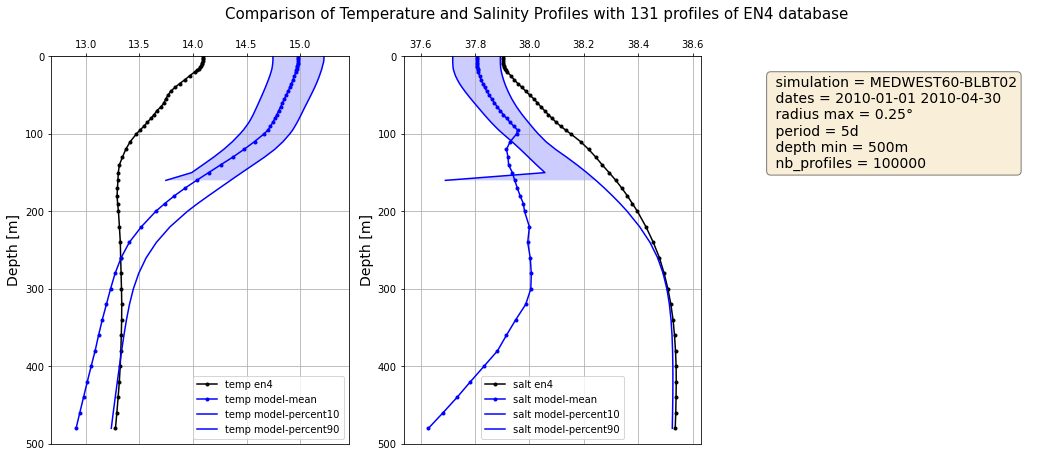

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))
axs = axs.ravel()
title = 'Comparison of Temperature and Salinity Profiles with '+str(nb_profilesEN4)+' profiles of EN4 database'
plt.suptitle(title,size = 15,y=1.05)
axs[0].plot(mean_all_temp_en4,vert_standart_red,'k.-', label='temp en4')
axs[0].plot(mean_all_temp_mean_model,vert_standart_red,'b.-', label='temp model-mean')
axs[0].set_ylabel('Depth [m]', size=14)
axs[0].set_xlim(left=min_temp-(max_temp-min_temp)/10,right=max_temp+(max_temp-min_temp)/10)
axs[0].set_ylim(depthmin, 0)
axs[0].grid(True, which='both')
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].plot(mean_all_temp_percent10_model,vert_standart_red,'b-', label='temp model-percent10')
axs[0].plot(mean_all_temp_percent90_model,vert_standart_red,'b-', label='temp model-percent90')
axs[0].fill_betweenx(vert_standart_red, mean_all_temp_percent10_model, x2=mean_all_temp_percent90_model, alpha=0.2, facecolor='b')
#        axs[0].set_title('Temperature profiles')
axs[0].legend()
        
axs[1].plot(mean_all_salt_en4,vert_standart_red,'k.-', label='salt en4')
axs[1].plot(mean_all_salt_mean_model,vert_standart_red,'b.-', label='salt model-mean')
axs[1].set_ylabel('Depth [m]', size=14)
axs[1].set_xlim(left=min_salt-(max_salt-min_salt)/10,right=max_salt+(max_salt-min_salt)/10)
axs[1].set_ylim(depthmin, 0)
axs[1].grid(True, which='both')
axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].plot(mean_all_salt_percent10_model,vert_standart_red,'b-', label='salt model-percent10')
axs[1].plot(mean_all_salt_percent90_model,vert_standart_red,'b-', label='salt model-percent90')
axs[1].fill_betweenx(vert_standart_red, mean_all_salt_percent10_model, x2=mean_all_salt_percent90_model, alpha=0.2, facecolor='b')
#        axs[1].set_title('Salinity profiles')
axs[1].legend()

textstr = '\n'.join((
            ' simulation = MEDWEST60-BLBT02',
            ' dates = '+str(datemin)+' '+str(datemax),
            ' radius max = '+str(radius_max)+'°',
            ' period = '+str(period)+'d',
            ' depth min = '+str(depthmin)+'m',
            ' nb_profiles = '+str(number_of_model_profiles)))        
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[2].text(0.05, 0.95, textstr, transform=axs[2].transAxes, fontsize=14,verticalalignment='top', bbox=props)
axs[2].axis('off')
fig.tight_layout()
plt.savefig('plots/profiles-TS-MEDWEST60-BLBT02_'+str(datemin)+'-'+str(datemax)+'_'+str(depthmin)+'m_'+str(radius_max)+'x'+str(period)+'d_'+str(number_of_model_profiles)+'.png',bbox_inches='tight')
